# CLASSICAL WAY

## Monte Carlo

Monte Carlo methods are a class of computational algorithms that are based on random sampling and repeated computation. At a high level, imagine you have a function (or equation) that is described by multiple variables and you're interested in solving that function, but it is analytically difficult to do so because the function depends on lots of complicated variables.



In [153]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [154]:
import numpy as np



S0 = 50  # initial price
K = 55  # strike price
r = 0.05  # risk-free rate
sigma = 0.4  # volatility
T = 1  # time to expiration
t = 30  # number of time steps
dt = T / t  # time step size
M = 1000  # number of simulations

 


S = np.zeros((t + 1, M))
S[0] = S0
for i in range(1, t + 1):
    S[i] = S[i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.randn(M))

P_call = sum(np.maximum(S[-1] - K, 0)) / M


print("The call option value is:  {:0.2f} Rs.\n".format(P_call))

The call option value is:  6.50 Rs.



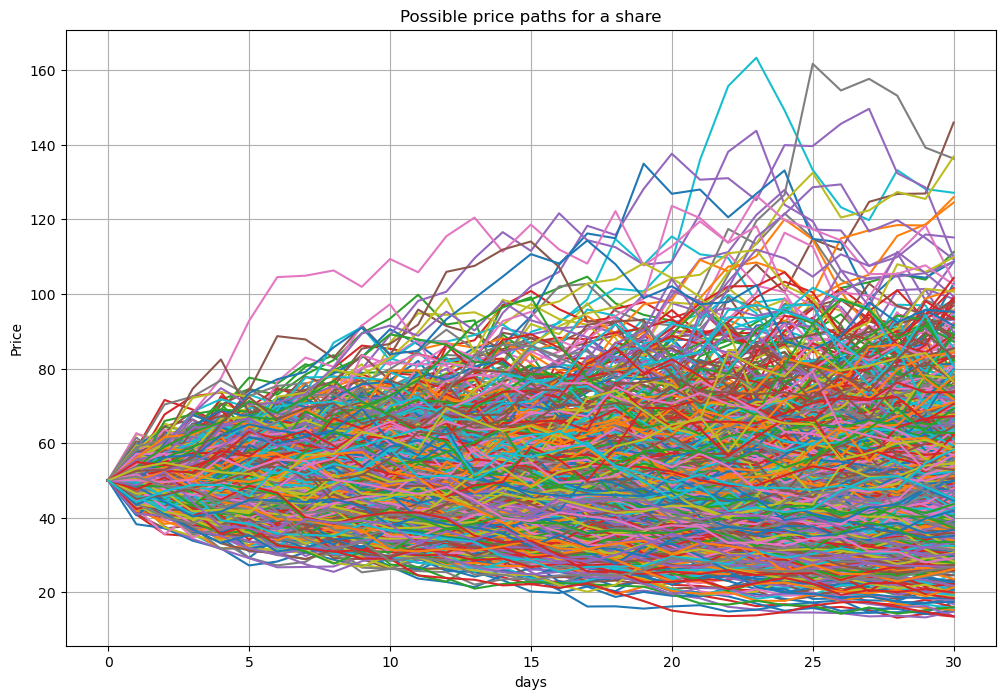

In [155]:
num_paths_to_plot = 1000
plt.figure(figsize= (12,8))
plt.plot(S[:, :num_paths_to_plot])
plt.grid(True)

plt.xlabel('days')
plt.ylabel('Price')
plt.title('Possible price paths for a share')
plt.show()

Let’s investigate the frequency of the simulated index levels at the end of the simulation period

Text(0, 0.5, 'frequency')

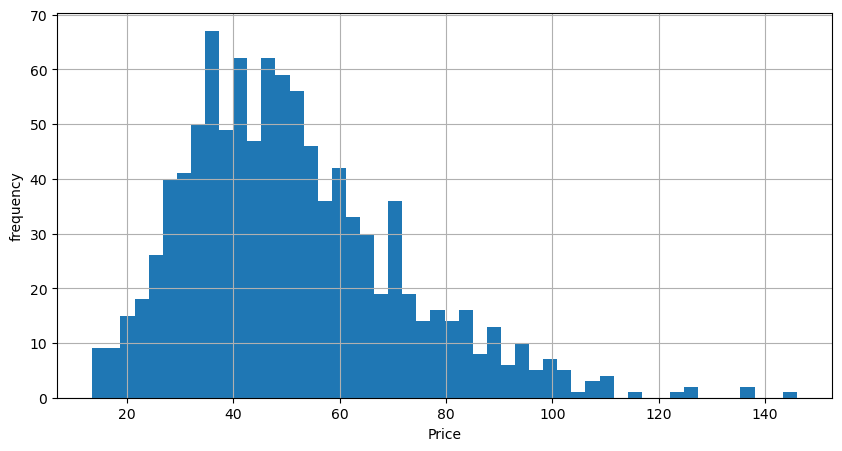

In [156]:
plt.figure(figsize= (10,5))
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('frequency')

Let’s look at the histogram of all simulated end-of-period option values

(5.0, 120.0)

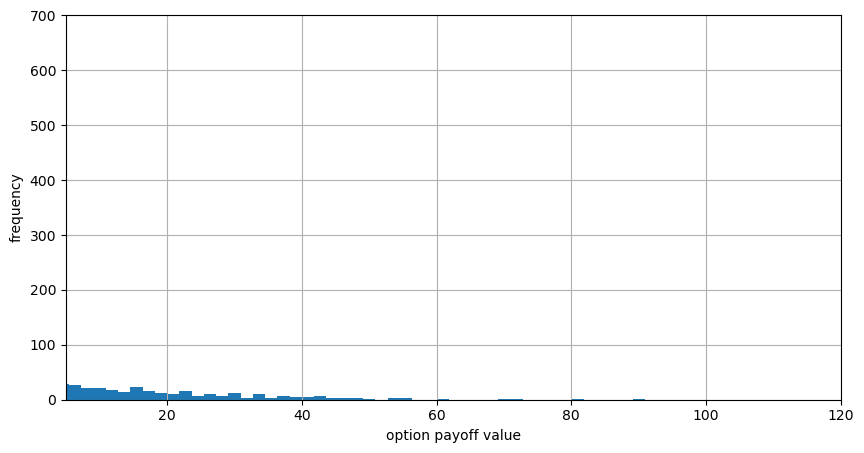

In [157]:
plt.figure(figsize= (10,5))
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option payoff value')
plt.ylabel('frequency')
plt.xlim((5,120))

# Pricing European Call Options 

# QUANTUM WAY

### Introduction
<br>
Suppose a <a href="http://www.theoptionsguide.com/call-option.aspx">European call option</a> with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:

$$\max\{S_T - K, 0\}$$

In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price before discounting, for the option:

$$\mathbb{E}\left[ \max\{S_T - K, 0\} \right]$$

as well as the corresponding $\Delta$, i.e., the derivative of the option price with respect to the spot price, defined as:

$$
\Delta = \mathbb{P}\left[S_T \geq K\right]
$$





1. **Define Parameters:**
   - Set inputs for the model: spot price (`S`), volatility (`vol`), risk-free rate (`r`), time to maturity (`T`).

2. **Model Uncertainty:**
   - Compute parameters for the log-normal distribution (`mu`, `sigma`).
   - Define bounds for the distribution (`low`, `high`).

3. **Construct Uncertainty Model:**
   - Use `LogNormalDistribution` to encode the probability distribution in a quantum state.

4. **Define Payoff Function:**
   - Set the strike price and construct a `LinearAmplitudeFunction` to model the European call option payoff.

5. **Build Quantum Circuit:**
   - Combine the uncertainty model and payoff function into a single quantum circuit.

6. **Set Up QAE Problem:**
   - Define the estimation problem (`EstimationProblem`) with the quantum circuit and objective qubit.

7. **Perform Amplitude Estimation:**
   - Use `IterativeAmplitudeEstimation` with precision (`epsilon`) and confidence (`alpha`) to estimate the expected payoff.

8. **Interpret Results:**
   - Output the estimated value (e.g., the price of the call option).


In [158]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

### Uncertainty Model

We construct a circuit to load a log-normal random distribution into a quantum state.
The distribution is truncated to a given interval $[\text{low}, \text{high}]$ and discretized using $2^n$ grid points, where $n$ denotes the number of qubits used.
The unitary operator corresponding to the circuit implements the following: 

$$\big|0\rangle_{n} \mapsto \big|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i}\big|i\rangle_{n},$$

where $p_i$ denote the probabilities corresponding to the truncated and discretized distribution and where $i$ is mapped to the right interval using the affine map:

$$ \{0, \ldots, 2^n-1\} \ni i \mapsto \frac{\text{high} - \text{low}}{2^n - 1} * i + \text{low} \in [\text{low}, \text{high}].$$

 

 
  - **Log-Normal Distribution:** Encodes uncertainty in asset prices as quantum amplitudes.
  - **Linear Amplitude Function:** Models the payoff, transforming amplitudes to represent financial outcomes.
  - These functions define how amplitudes are distributed across quantum states.
 


In [159]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 50  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 5%
T = 30 / 365  # 30 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
 
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

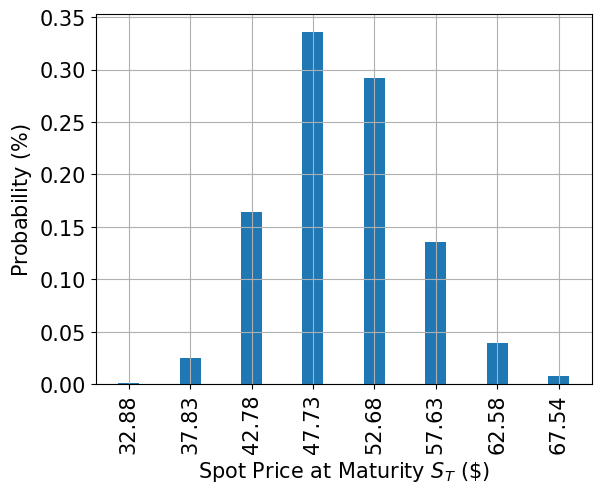

In [160]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=1.7)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

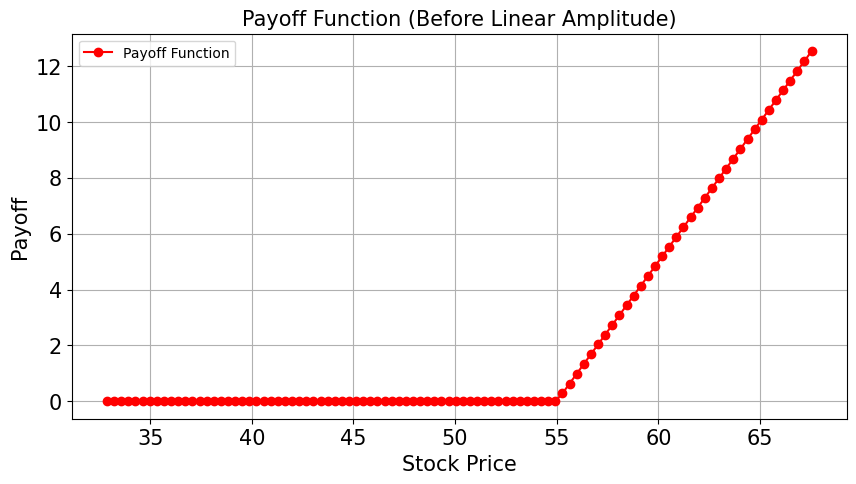

In [161]:
strike_price = 55

# Generate stock prices (x) from low to high
x = np.linspace(low, high, 100)

# Calculate the payoff (y)
y = np.maximum(0, x - strike_price)

# Plot the payoff function
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ro-', label="Payoff Function")
plt.grid(True)
plt.title('Payoff Function (Before Linear Amplitude)', size=15)
plt.xlabel('Stock Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend()
plt.show()


In [162]:
 
strike_price = 55

 
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
 
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

 
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

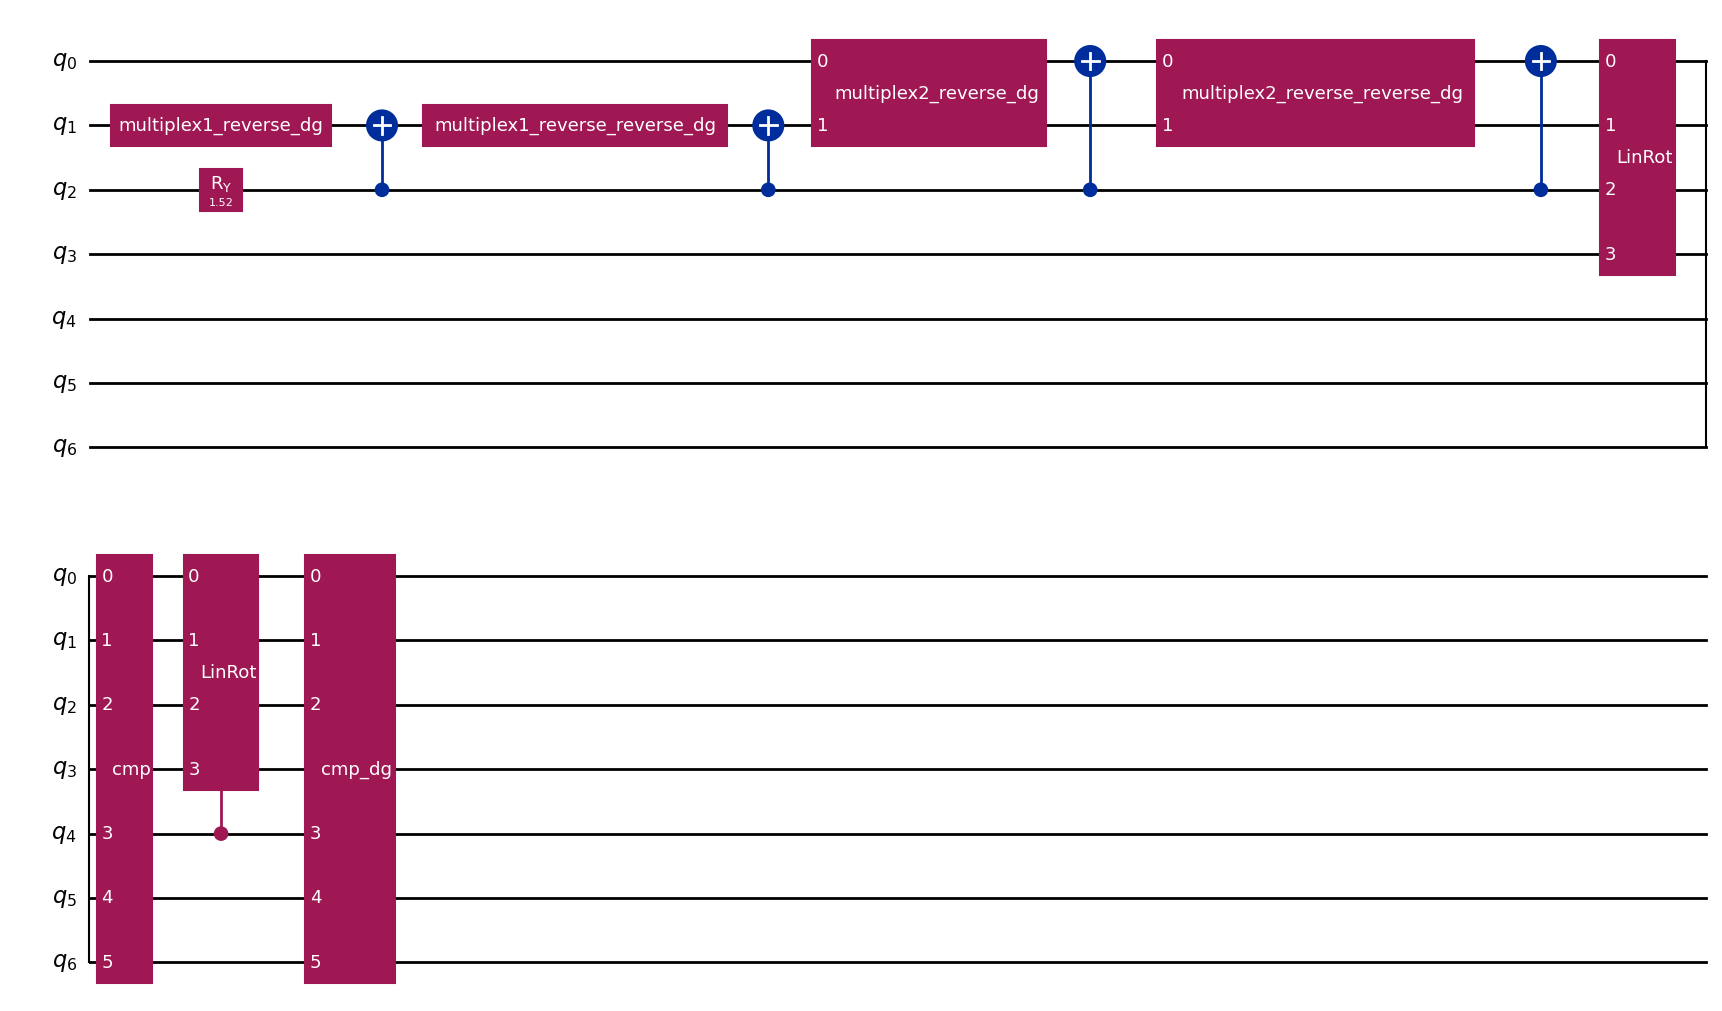

In [169]:
european_call.decompose(reps=3).draw(output='mpl')


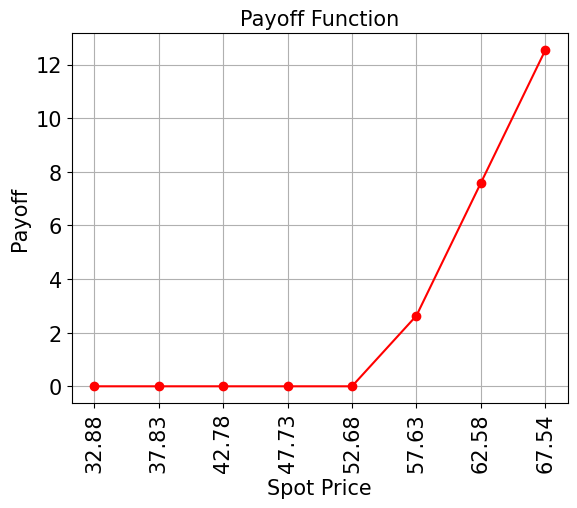

In [163]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [164]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % (exact_value ))
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.7483
exact delta value:   	0.1819


### Evaluate Expected Payoff

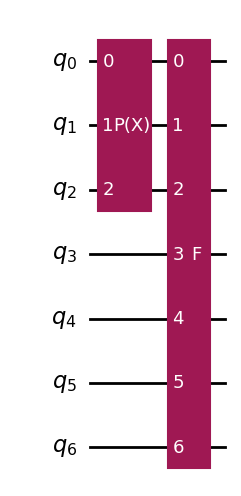

In [165]:
european_call.draw(output='mpl')

In [170]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.00001
shots=10000
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
 
# Create the Sampler primitive
sampler = Sampler()

# Set the run options for the Sampler
sampler.options.shots = shots
sampler.options.seed_simulator = 27

# Perform amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, sampler=sampler)
result = ae.estimate(problem)

print(result)


{   'alpha': 1e-05,
    'circuit_results': None,
    'confidence_interval': [0.33038628960513305, 0.33207018373346864],
    'confidence_interval_processed': (0.8534207033711714, 0.9071714224241165),
    'epsilon_estimated': 0.0008419470641677917,
    'epsilon_estimated_processed': 0.026875359526472575,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.30717148093312213, 0.3525692660575751],
                              [0.33038628960513305, 0.33207018373346864]],
    'estimation': 0.33122823666930085,
    'estimation_processed': 0.880296062897644,
    'num_oracle_queries': 130000,
    'powers': [0, 0, 13],
    'ratios': [1.0, 27.0],
    'shots': None,
    'theta_intervals': [   [0, 0.25],
                           [0.09349369993230566, 0.1011816242108228],
                           [0.09745859532107905, 0.09774330524098067]]}


In [167]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print('Estimation error:    \t%.4f' %(np.abs(exact_value-result.estimation_processed)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.7483
Estimated value:    	0.8803
Estimation error:    	0.1320
Confidence interval:	[0.8534, 0.9072]


In [168]:
expected_payoff = exact_value * f_max
 
discount_factor = np.exp(-r * T)
option_price = expected_payoff * discount_factor

 
print(f"Expected payoff at maturity: {expected_payoff:.4f}")
print(f"Discount factor: {discount_factor:.4f}")
print(f"Final option price (present value): {option_price:.4f}")

Expected payoff at maturity: 9.3804
Discount factor: 0.9959
Final option price (present value): 9.3419
